In [9]:
# Imports
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skspatial.objects import Line, Points, Plane
import yaml
import urllib.request
import os
import math

In [2]:
def open_line(file_name):
    '''
    Opens one of the text files and parses the line into a skspatial object
    '''
    
    with open(file_name) as f:
        lines = f.readlines()

    point = [float(dim) for dim in lines[0].split()[1:]]
    line = [float(dim) for dim in lines[1].split()[1:]]
    
    return Line(point, line)

In [3]:
def open_carbon_atoms(file_name):    
    
    with open(file_name) as pdb_structure:
        lines = pdb_structure.readlines()

    allCA = list()

    for line in lines:
        line = line[:22] + ' ' + line[22:] # correct .pdb stupidity        

        if len(line.split()) > 5:
            residue_num = int(line.split()[5])
            chain = line.split()[4]
        else:
            continue
        
        if 'CA' in line:
            x = float(line.split()[6])
            y = float(line.split()[7])
            z = float(line.split()[8])
            data = [x,y,z]
            allCA.append(data)   

    return np.array(allCA)

In [4]:
# This is the parameter that determines how far apart the orthogonal planes are from each other.
distance_between_planes = 10

# This is the parameter that determines the radius from the middle line that is used to check 
# for atoms to use for calculations for measurement of channel radius.
radius_to_check_for_atoms = 20

with open('../CONFIG/config_alignment.yaml', 'r') as f:
    pdb_ids = yaml.load(f, Loader=yaml.FullLoader)
lines, points_array = [], []
for channel in pdb_ids.keys():
    for ref_struct_id in pdb_ids[channel]:
        for ref_struct in list(ref_struct_id.keys()):
            for struct in list(ref_struct_id.values())[0]:
                lines.append(open_line(f"line_{ref_struct}.txt"))
                points_array.append(open_carbon_atoms(f"../DATA/ALIGNED/{channel}/{struct}.pdb"))

lines = np.array(lines)
points_array = np.array(points_array)


ipykernel_launcher:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [13]:
def channel_mouth(line, quadrants, first_plane, second_plane):
    segment_atoms= []

    smallest_radii = []
    largest_radii = []

    for segment in quadrants:
        atoms = []
        avg_small_radius = 0
        avg_large_radius = 0
        for quadrant in segment:
            if len(quadrant) < 1: 
                continue

            for atom in quadrant:
                x = first_plane.distance_point(atom) * first_plane.side_point(atom)
                y = second_plane.distance_point(atom) * second_plane.side_point(atom)
                theta = np.arctan2(x,y)
                r = line.distance_point(atom)
                atoms.append([r,theta])
        
            smallest_radius = np.min([line.distance_point(atom) for atom in quadrant])
            largest_radius = np.max([line.distance_point(atom) for atom in quadrant])
            avg_small_radius += smallest_radius
            avg_large_radius += largest_radius

        avg_small_radius /= 4
        avg_large_radius /= 4

        if avg_small_radius > 0 and avg_large_radius > 0:
            smallest_radii.append(avg_small_radius)
            largest_radii.append(avg_large_radius)
        if len(atoms) > 1:
            atoms = sorted(atoms, key = lambda x:x[1]) 
            atoms = np.array(atoms)
            segment_atoms.append(atoms)

    segment_atoms = np.array(segment_atoms)
    smallest_radii = np.array(smallest_radii)
    print(smallest_radii)
    print(largest_radii)


    figure, ax = plt.subplots()
    x_value, y_value = [], []

    for atom in segment_atoms[2]:
        x_value.append(atom[0]*math.cos(atom[1]))
        y_value.append(atom[0]*math.sin(atom[1]))
    ax.plot(x_value, y_value, color = "blue")

    x_value, y_value = [], []
    for atom in segment_atoms[2]:
        x_value.append(smallest_radii[1]*math.cos(atom[1]))
        y_value.append(smallest_radii[1]*math.sin(atom[1]))
    ax.plot(x_value, y_value, color = "red")

    x_value, y_value = [], []
    for atom in segment_atoms[2]:
        x_value.append(largest_radii[1]*math.cos(atom[1]))
        y_value.append(largest_radii[1]*math.sin(atom[1]))
    ax.plot(x_value, y_value, color = "green")

In [11]:
def create_segments(line, points, first_plane, second_plane):
    # Separate the line/channel into arbitrary size length. Create orthogonal planes to the two perpendicular planes.

    plane_points = np.array([line.point + line.vector * i for i in range(-100, 100, distance_between_planes)])
    orthogonal_planes = np.array([Plane(plane_points[i], line.vector) for i in range(plane_points.shape[0])])

    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)

    line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
    ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')

    for plane in orthogonal_planes:
        plane.plot_3d(ax, lims_x = (-40, 40), lims_y = (-40, 40), color = 'y', alpha = 0.5)

    ax.set_label(['x','y','z'])
    plt.show()

    # Determine what quadrant carbon atoms are in

    quadrants = np.ndarray((orthogonal_planes.shape[0] - 1, 4), object)

    for i in range(orthogonal_planes.shape[0] - 1):
        quadrant_1, quadrant_2, quadrant_3, quadrant_4 = [], [], [], []
    
        for atom in points:
            if orthogonal_planes[i].side_point(atom) > 0 and orthogonal_planes[i + 1].side_point(atom) < 0:
                if line.distance_point(atom) < radius_to_check_for_atoms:
                    if first_plane.side_point(atom) < 0 and second_plane.side_point(atom) > 0:
                        quadrant_1.append(atom)                    
                    elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) > 0:
                        quadrant_2.append(atom)                    
                    elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) < 0:
                        quadrant_3.append(atom)                    
                    elif first_plane.side_point(atom) < 0 and second_plane.side_point(atom) < 0:
                        quadrant_4.append(atom)
    
        quadrants[i][0] = quadrant_1
        quadrants[i][1] = quadrant_2
        quadrants[i][2] = quadrant_3
        quadrants[i][3] = quadrant_4

    print("Number of points per quadrant:")
    print("N.B. shape = (number of planes x number of quadrants)")
    for plane in quadrants:
        print([len(plane[i]) for i in range(4)])
    channel_mouth(line, quadrants, first_plane, second_plane)

In [6]:
def do_everything(line, points):
    origin = [0, 0, 0]
    origin_projection = line.project_point(origin)
    perpendicular_line = Line(origin_projection, origin - origin_projection)
    normal_vector = perpendicular_line.vector.cross(line.vector)
    first_plane = Plane(origin_projection, normal_vector)
    second_plane = Plane(origin_projection, line.vector.cross(normal_vector))
    fig = plt.figure(figsize=(8,8))
    ax = Axes3D(fig)

    line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
    first_plane.plot_3d(ax, lims_x = (-20, 20), lims_y = (-20, 20), alpha = 0.5)
    second_plane.plot_3d(ax, lims_x = (-20, 20), lims_y = (-20, 20), alpha = 0.5)
    ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')
    ax.scatter(line.point[0], line.point[1], line.point[2], c = 'y', marker = 'o')
    ax.set_label(['x','y','z'])
    plt.show()
    create_segments(line, points, first_plane, second_plane)

ipykernel_launcher:9: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


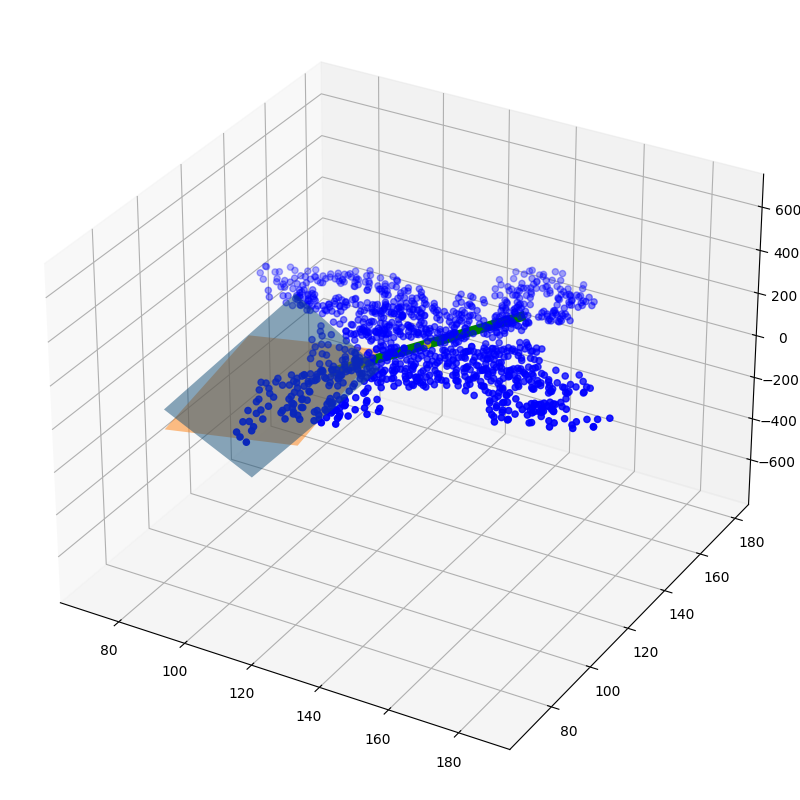

ipykernel_launcher:8: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.


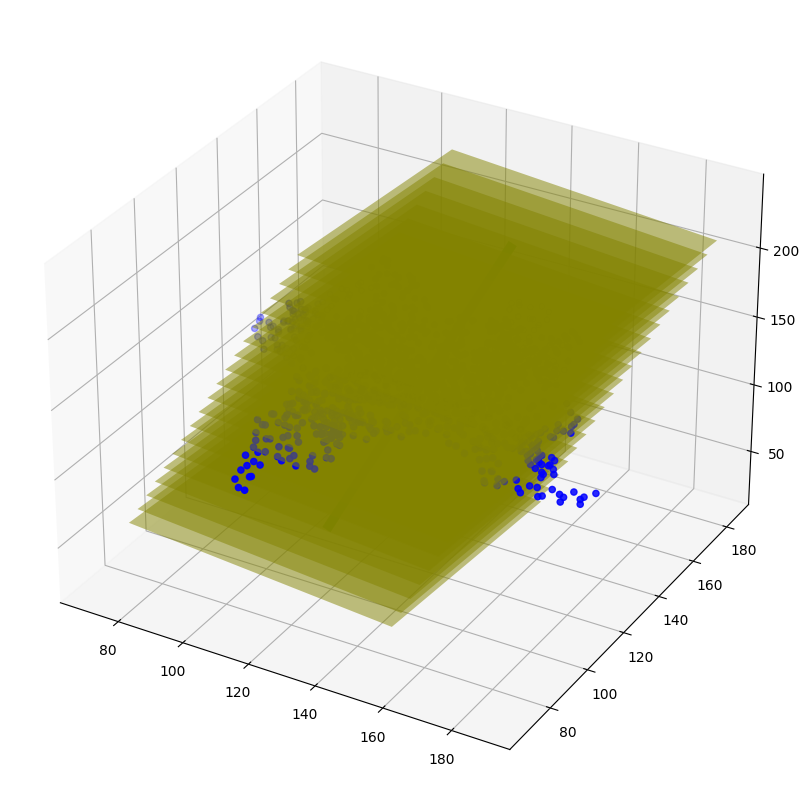

Number of points per quadrant:
N.B. shape = (number of planes x number of quadrants)
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[3, 1, 0, 0]
[5, 4, 3, 1]
[18, 9, 15, 6]
[16, 16, 16, 17]
[15, 20, 14, 16]
[17, 13, 13, 13]
[19, 17, 20, 20]
[9, 12, 6, 9]
[2, 3, 0, 7]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]


ipykernel_launcher:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[ 9.54813304 11.73148423  8.35579822  8.27424363  5.20541639  8.78941617
  6.29013582  7.95733779 10.68378437]
[9.751197226581274, 16.881787523092164, 19.46604389218782, 19.593384967129644, 19.52406852719998, 19.311417175310734, 19.787741995800364, 16.0706883019751, 13.027078518193523]


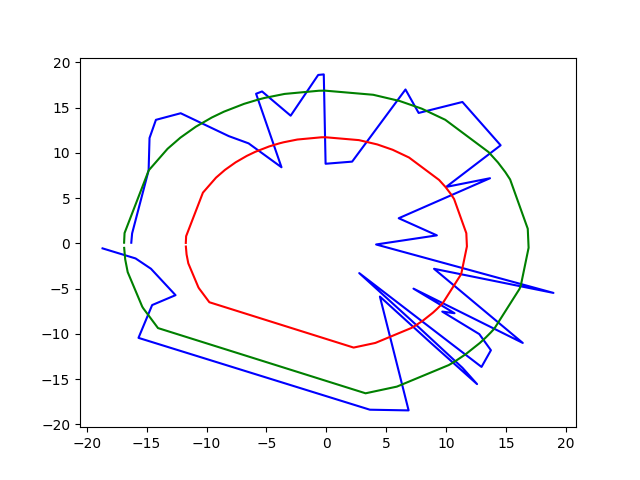

In [14]:
# file_name = "7EJ1"
# channel_type = "KCN"

# # This is the parameter that determines how far apart the orthogonal planes are from each other.
# distance_between_planes = 10

# # This is the parameter that determines the radius from the middle line that is used to check 
# # for atoms to use for calculations for measurement of channel radius.
# radius_to_check_for_atoms = 20
# # Open line and carbon atoms for 6V01

# Show Mark problem with 6V01
# line = open_line(f"line_{file_name}.txt")
# points = open_carbon_atoms(f"../DATA/ALIGNED/{channel_type}/{file_name}.pdb")

for line, points in zip(lines, points_array):
    do_everything(line, points)
    break
# Generate planes

# origin = [0, 0, 0]
# origin_projection = line.project_point(origin)
# perpendicular_line = Line(origin_projection, origin - origin_projection)
# normal_vector = perpendicular_line.vector.cross(line.vector)
# first_plane = Plane(origin_projection, normal_vector)
# second_plane = Plane(origin_projection, line.vector.cross(normal_vector))



/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


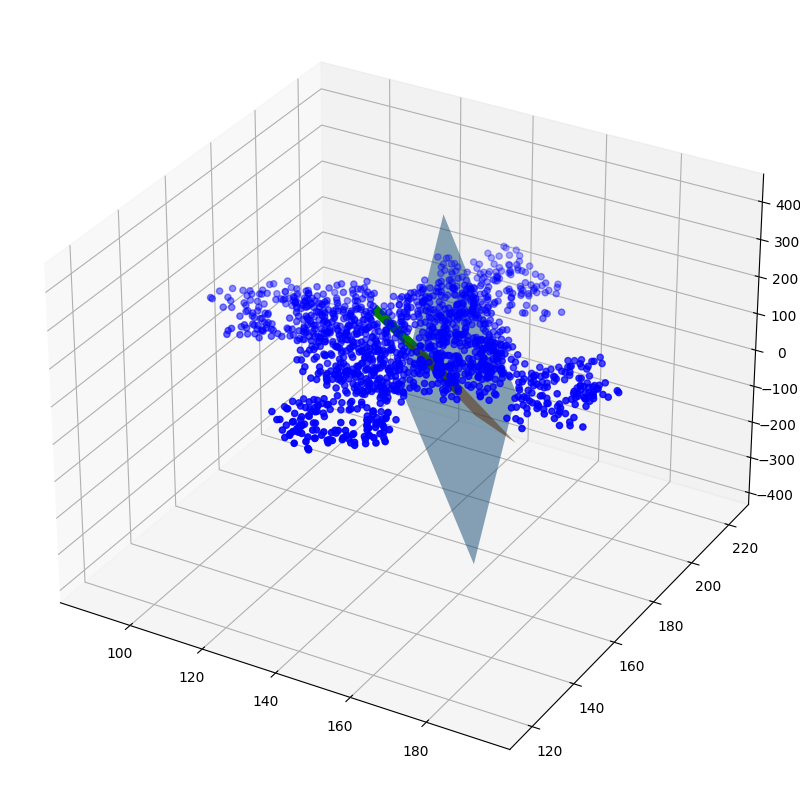

In [11]:
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
first_plane.plot_3d(ax, lims_x = (-10, 10), lims_y = (-10, 10), alpha = 0.5)
second_plane.plot_3d(ax, lims_x = (-10, 10), lims_y = (-10, 10), alpha = 0.5)
ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')
ax.scatter(line.point[0], line.point[1], line.point[2], c = 'y', marker = 'o')
ax.set_label(['x','y','z'])
plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  import sys


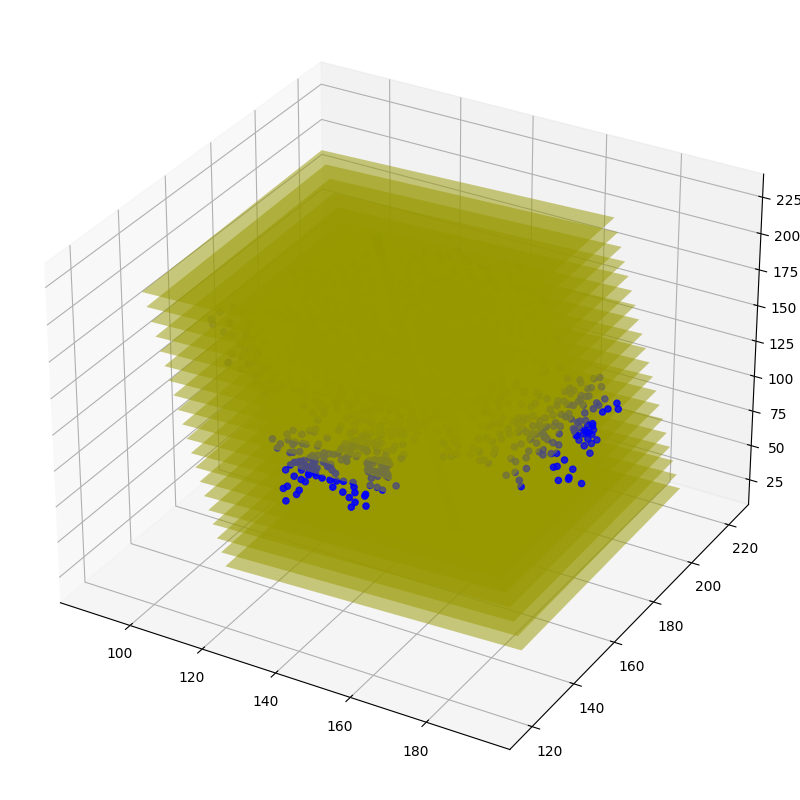

In [6]:
# Separate the line/channel into arbitrary size length. Create orthogonal planes to the two perpendicular planes.

plane_points = np.array([line.point + line.vector * i for i in range(-100, 100, distance_between_planes)])
orthogonal_planes = np.array([Plane(plane_points[i], line.vector) for i in range(plane_points.shape[0])])

fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)

line.plot_3d(ax, -100, 100, linewidth = 7, c = 'g')
ax.scatter(points[:,0], points[:,1], points[:,2], c = 'b', marker = 'o')

for plane in orthogonal_planes:
    plane.plot_3d(ax, lims_x = (-40, 40), lims_y = (-40, 40), color = 'y', alpha = 0.5)

ax.set_label(['x','y','z'])
plt.show()

In [7]:
# Determine what quadrant carbon atoms are in

quadrants = np.ndarray((orthogonal_planes.shape[0] - 1, 4), object)

for i in range(orthogonal_planes.shape[0] - 1):
    quadrant_1, quadrant_2, quadrant_3, quadrant_4 = [], [], [], []
    
    for atom in points:
        if orthogonal_planes[i].side_point(atom) > 0 and orthogonal_planes[i + 1].side_point(atom) < 0:
            if line.distance_point(atom) < radius_to_check_for_atoms:
                if first_plane.side_point(atom) < 0 and second_plane.side_point(atom) > 0:
                    quadrant_1.append(atom)                    
                elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) > 0:
                    quadrant_2.append(atom)                    
                elif first_plane.side_point(atom) > 0 and second_plane.side_point(atom) < 0:
                    quadrant_3.append(atom)                    
                elif first_plane.side_point(atom) < 0 and second_plane.side_point(atom) < 0:
                    quadrant_4.append(atom)
    
    quadrants[i][0] = quadrant_1
    quadrants[i][1] = quadrant_2
    quadrants[i][2] = quadrant_3
    quadrants[i][3] = quadrant_4

print("Number of points per quadrant:")
print("N.B. shape = (number of planes x number of quadrants)")
for plane in quadrants:
    print([len(plane[i]) for i in range(4)])

Number of points per quadrant:
N.B. shape = (number of planes x number of quadrants)
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[0, 0, 0, 0]
[2, 2, 2, 2]
[12, 12, 12, 12]
[20, 20, 20, 20]
[18, 18, 18, 18]
[17, 17, 17, 17]
[12, 12, 12, 12]
[3, 3, 3, 3]
[14, 14, 14, 14]
[14, 14, 14, 14]
[18, 18, 18, 18]
[8, 8, 8, 8]
[0, 0, 0, 0]
[0, 0, 0, 0]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:39: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


[15.66349358  3.98708953  4.07595417  4.47547827  7.32857909  9.48619863
 16.76320965  6.48528591  8.15040935  6.38475031 11.12395648]
[17.099513289267694, 17.603611045068206, 17.168737221877173, 16.933753632691733, 17.766541986886082, 17.743033989555002, 17.458865482879432, 17.594029675935534, 17.21565668569974, 16.76357491755812, 17.7529914193431]


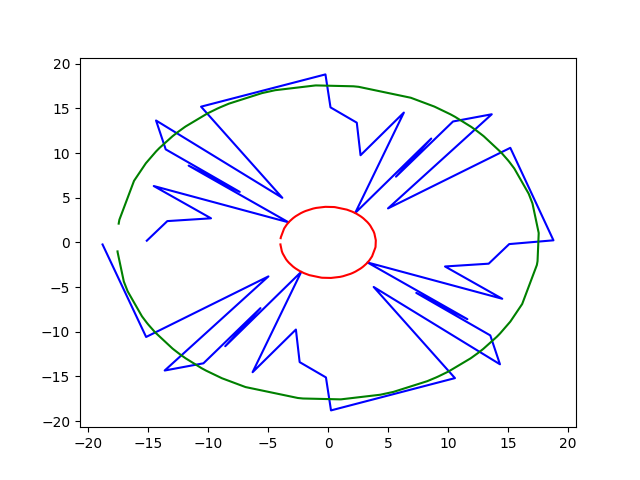

In [8]:

import math

segment_atoms= []

smallest_radii = []
largest_radii = []

for segment in quadrants:
    atoms = []
    avg_small_radius = 0
    avg_large_radius = 0
    for quadrant in segment:
        if len(quadrant) < 1: 
            continue

        for atom in quadrant:
            x = first_plane.distance_point(atom) * first_plane.side_point(atom)
            y = second_plane.distance_point(atom) * second_plane.side_point(atom)
            theta = np.arctan2(x,y)
            r = line.distance_point(atom)
            atoms.append([r,theta])
        
        smallest_radius = np.min([line.distance_point(atom) for atom in quadrant])
        largest_radius = np.max([line.distance_point(atom) for atom in quadrant])
        avg_small_radius += smallest_radius
        avg_large_radius += largest_radius

    avg_small_radius /= 4
    avg_large_radius /= 4

    if avg_small_radius > 0 and avg_large_radius > 0:
        smallest_radii.append(avg_small_radius)
        largest_radii.append(avg_large_radius)
    if len(atoms) > 1:
        atoms = sorted(atoms, key = lambda x:x[1]) 
        atoms = np.array(atoms)
        segment_atoms.append(atoms)

segment_atoms = np.array(segment_atoms)
smallest_radii = np.array(smallest_radii)
print(smallest_radii)
print(largest_radii)


figure, ax = plt.subplots()
x_value, y_value = [], []

for atom in segment_atoms[1]:
     x_value.append(atom[0]*math.cos(atom[1]))
     y_value.append(atom[0]*math.sin(atom[1]))
ax.plot(x_value, y_value, color = "blue")

x_value, y_value = [], []
for atom in segment_atoms[2]:
     x_value.append(smallest_radii[1]*math.cos(atom[1]))
     y_value.append(smallest_radii[1]*math.sin(atom[1]))
ax.plot(x_value, y_value, color = "red")

x_value, y_value = [], []
for atom in segment_atoms[2]:
     x_value.append(largest_radii[1]*math.cos(atom[1]))
     y_value.append(largest_radii[1]*math.sin(atom[1]))
ax.plot(x_value, y_value, color = "green")